# Import Libraries

In [1]:
import os
import seaborn as sns
import pandas as pd
import numpy as np

import plotly.express as px
import plotly.graph_objects as go
from matplotlib import pyplot as plt
from matplotlib.colors import LinearSegmentedColormap
from mpl_toolkits.mplot3d import Axes3D

from scipy.stats.mstats import winsorize
from scipy.interpolate import griddata

from sklearn.cluster import KMeans
from sklearn.neighbors import NearestNeighbors
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score

import pickle as pkl

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Load Data

In [3]:
curr_dir = (os.getcwd()).replace('\\', '/')
data_path = (os.path.join(curr_dir, 'Data')).replace('\\', '/')

In [4]:
str_sed_data = pd.read_csv(data_path + '/Kodangal dataset/clean_Kodangal_gcM.csv')

In [5]:
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,toposheet,sio2,al2o3,fe2o3,tio2,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,56G04,44.750,9.414,3.312,0.543,...,5.746369,0.862203,0.991997,1.811020,0.052741,322.0,0.101815,0.293517,17.0,50.0
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,56G04,45.129,9.853,3.748,0.580,...,7.857656,0.958655,0.943758,2.203597,0.048799,336.0,0.072979,0.300787,8.0,50.0
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,56G04,58.283,12.534,7.768,1.321,...,8.728652,1.428838,1.682294,2.711943,0.126064,205.0,0.121959,0.481961,12.0,50.0
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,56G04,61.180,11.670,8.340,1.420,...,9.365000,1.542800,1.803219,2.982200,0.084033,230.0,0.071592,0.427797,10.0,50.0
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,56G04,60.300,11.470,8.270,1.430,...,10.693400,1.467300,1.451395,3.249200,0.083470,300.0,0.067475,0.447018,6.0,50.0


In [6]:
sed_max_long = max(str_sed_data['longitude'])
sed_min_long = min(str_sed_data['longitude'])

sed_max_lat = max(str_sed_data['latitude'])
sed_min_lat = min(str_sed_data['latitude'])

print("Stream Sediment coordinates - ")

print(f"Maximum longitude co-ordinate: {sed_max_long}")
print(f"Minimum longitude co-ordinate: {sed_min_long}")

print(f"Maximum latitude co-ordinate: {sed_max_lat}")
print(f"Minimum latitude co-ordinate: {sed_min_lat}")

Stream Sediment coordinates - 
Maximum longitude co-ordinate: 77.98508
Minimum longitude co-ordinate: 77.25
Maximum latitude co-ordinate: 17.24396
Minimum latitude co-ordinate: 17.00904


# EDA

In [8]:
str_elem = []

for col in list(str_sed_data.columns):
    if col not in ['gid', 
                   'objectid', 
                   'sampleno', 
                   'longitude', 
                   'latitude', 
                   'toposheet']:
        str_elem.append(col)

In [9]:
len(str_elem)

62

## Outliers

In [136]:
au_outl = str_sed_data[str_sed_data['au'] >= 15]
au_outl

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,ta,w,u,toposheet,in_,f,te,tl,hg,cd
312,275131,276786,56G12/110/SS/18-19,77.716160,17.135530,66.79,15.40,3.59,0.60,1.58,...,0.80827,0.762251,5.275063,56G12,0.060781,220.0,0.094335,0.368781,7.0,50.0
423,275236,276891,56G16/019/S/2018,77.834530,17.027110,54.69,18.56,6.47,1.09,2.29,...,2.25000,0.824327,8.850000,56G16,0.116336,253.0,0.196169,0.734126,132.0,50.0
456,275271,276926,56G16/054/S/2018,77.966070,17.063250,58.81,20.06,5.21,0.84,0.90,...,1.68000,1.399279,9.430000,56G16,0.064886,161.0,0.119798,0.833472,37.0,50.0
470,275286,276941,56G16/069/S/2018,77.984890,17.081320,56.85,15.89,6.18,1.18,2.64,...,1.49000,0.760840,4.880000,56G16,0.065827,206.0,0.062427,0.637490,72.0,50.0
863,86385,86568,56H09/091/S/14,77.621667,16.867222,63.24,14.91,3.83,0.70,3.53,...,1.25000,0.000000,6.800000,56H09,0.000000,0.0,0.000000,0.000000,0.0,50.0
928,86610,86793,56H09/161/S/14,77.621667,16.957500,62.07,15.59,3.24,0.77,1.71,...,3.07000,0.700000,9.980000,56H09,0.000000,0.0,0.000000,0.000000,9.0,50.0
959,86796,86979,56H09/194/S/14,77.715556,16.993333,55.29,15.36,6.13,1.05,4.35,...,0.84000,1.910000,6.820000,56H09,0.000000,0.0,0.000000,0.000000,165.0,50.0


- Run this code for Au

In [137]:
# Assuming you define 'neighbors' based on some logical geographical proximity
nbrs = NearestNeighbors(n_neighbors=5, 
                        algorithm='ball_tree').fit(str_sed_data[['latitude', 
                                                                 'longitude']])
distances, indices = nbrs.kneighbors(str_sed_data[['latitude', 
                                                   'longitude']])

for index, row in au_outl.iterrows():
    # Calculate the mean of the nearest neighbors excluding the outlier itself
    neighbor_indices = indices[index][1:]  # exclude the first index since it's the point itself
    mean_au = str_sed_data.iloc[neighbor_indices]['au'].mean()
    str_sed_data.at[index, 'au'] = mean_au

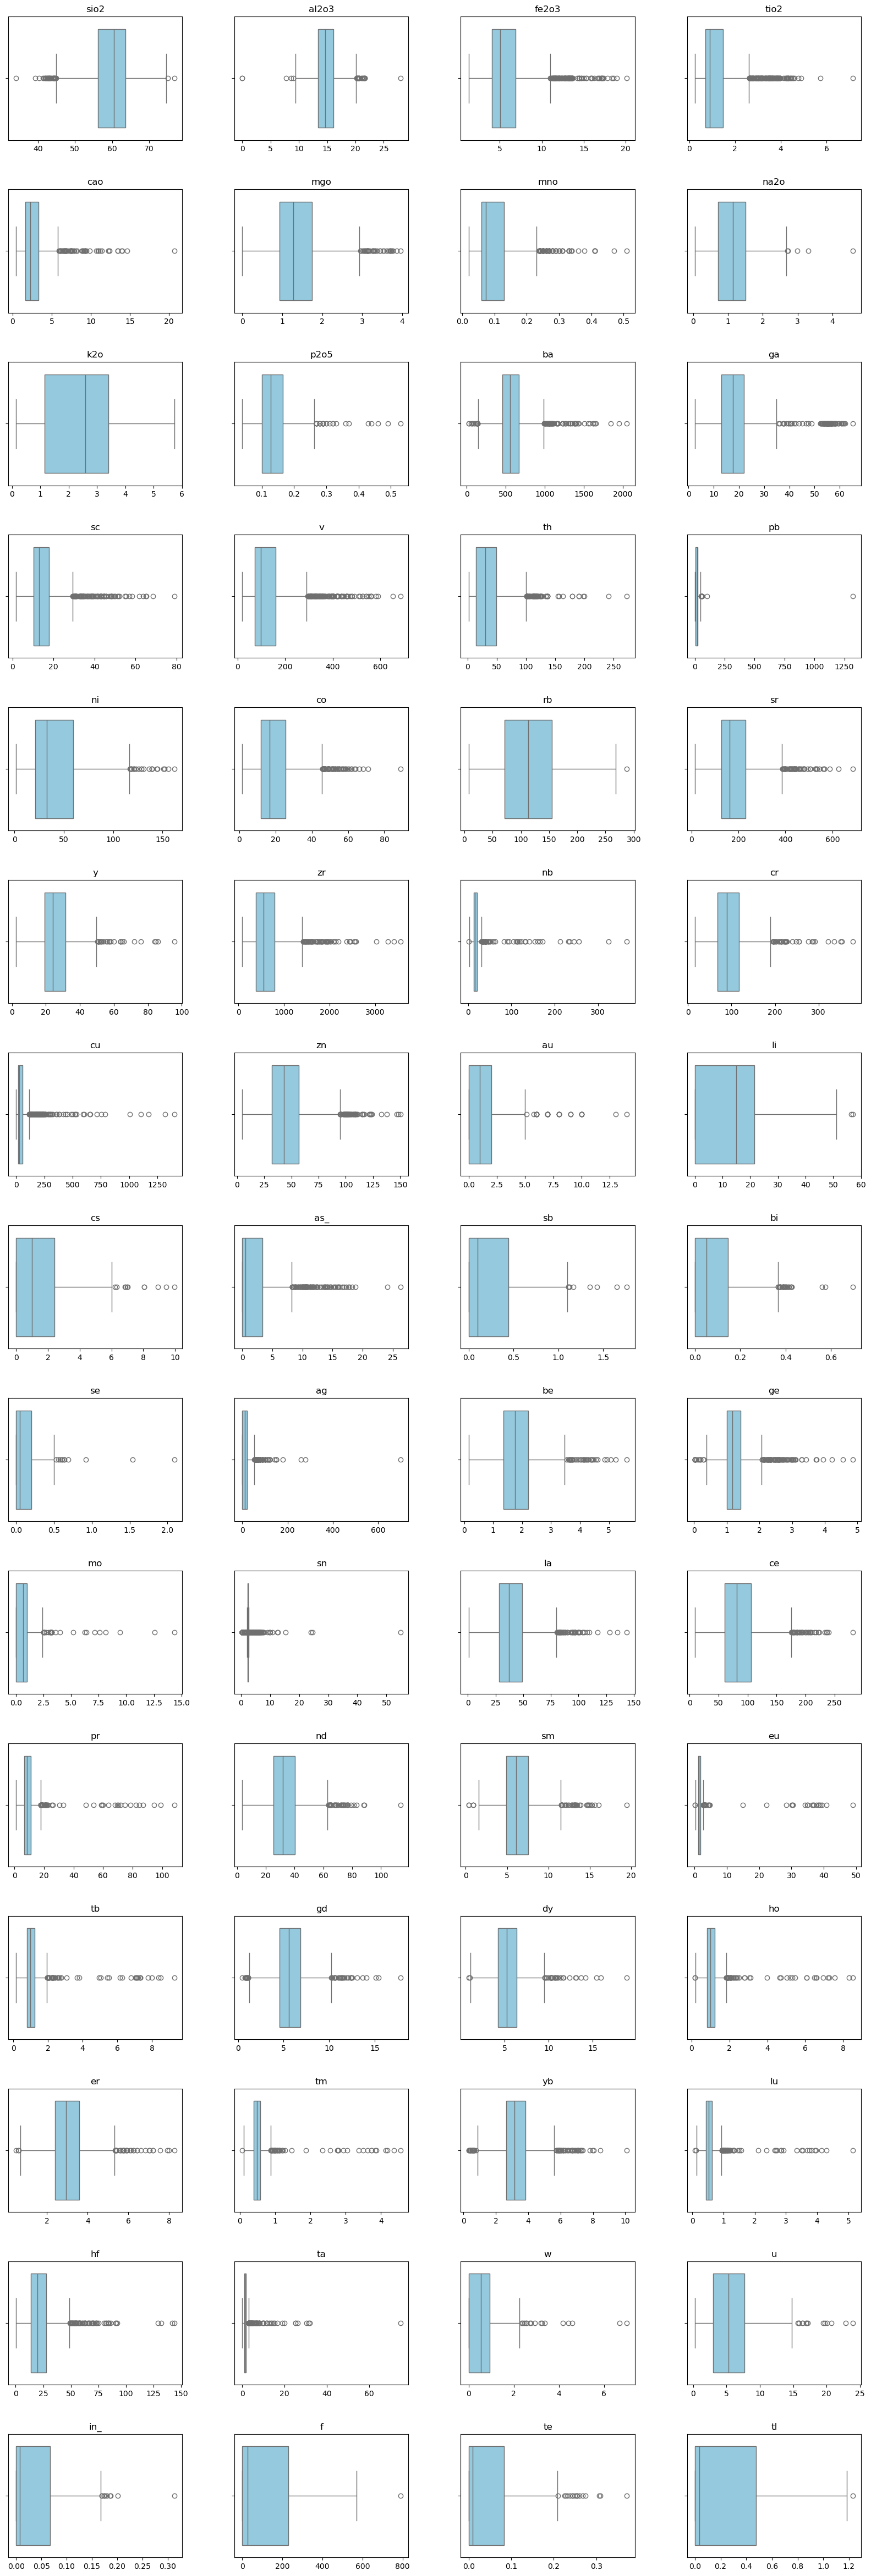

In [138]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_sed_data[str_elem].columns, axes.flatten())):
    sns.boxplot(x=str_sed_data[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

- Detecting outliers via Inter-Quartile Range and handling using winsorize capping method
- Do this only for Zr, Cu, La

In [143]:
for elem in list(str_sed_data[str_elem].columns):
    if elem == 'zr':
        Q1 = str_sed_data[elem].quantile(0.25)
        Q3 = str_sed_data[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)

        print(upr_bnd)

        print('87\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.87)))
        print('90\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.90)))
        print('92.5\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.925)))
        print('95\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.95)))
        print('97.5\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.975)))
        print('99\u1d57\u02b0 Percentile: {}'.format(str_sed_data[elem].quantile(0.99)))
    
        # str_sed_data[elem] = str_sed_data[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)

1411.875
87ᵗʰ Percentile: 978.525
90ᵗʰ Percentile: 1072.6999999999998
92.5ᵗʰ Percentile: 1218.375
95ᵗʰ Percentile: 1474.125
97.5ᵗʰ Percentile: 1817.2649999999999
99ᵗʰ Percentile: 2151.86


In [144]:
str_sed_data['zr'] = winsorize(str_sed_data['zr'], limits=(0.05, 0.05))

In [145]:
for elem in str_elem:
    if elem not in ['au', 'zr', 'cu', 'la']:
        Q1 = str_sed_data[elem].quantile(0.25)
        Q3 = str_sed_data[elem].quantile(0.75)
        IQR = Q3 - Q1
        lwr_bnd = Q1 - (1.5 * IQR)
        upr_bnd = Q3 + (1.5 * IQR)
    
        str_sed_data[elem] = str_sed_data[elem].apply(lambda x: upr_bnd if x > upr_bnd else x)

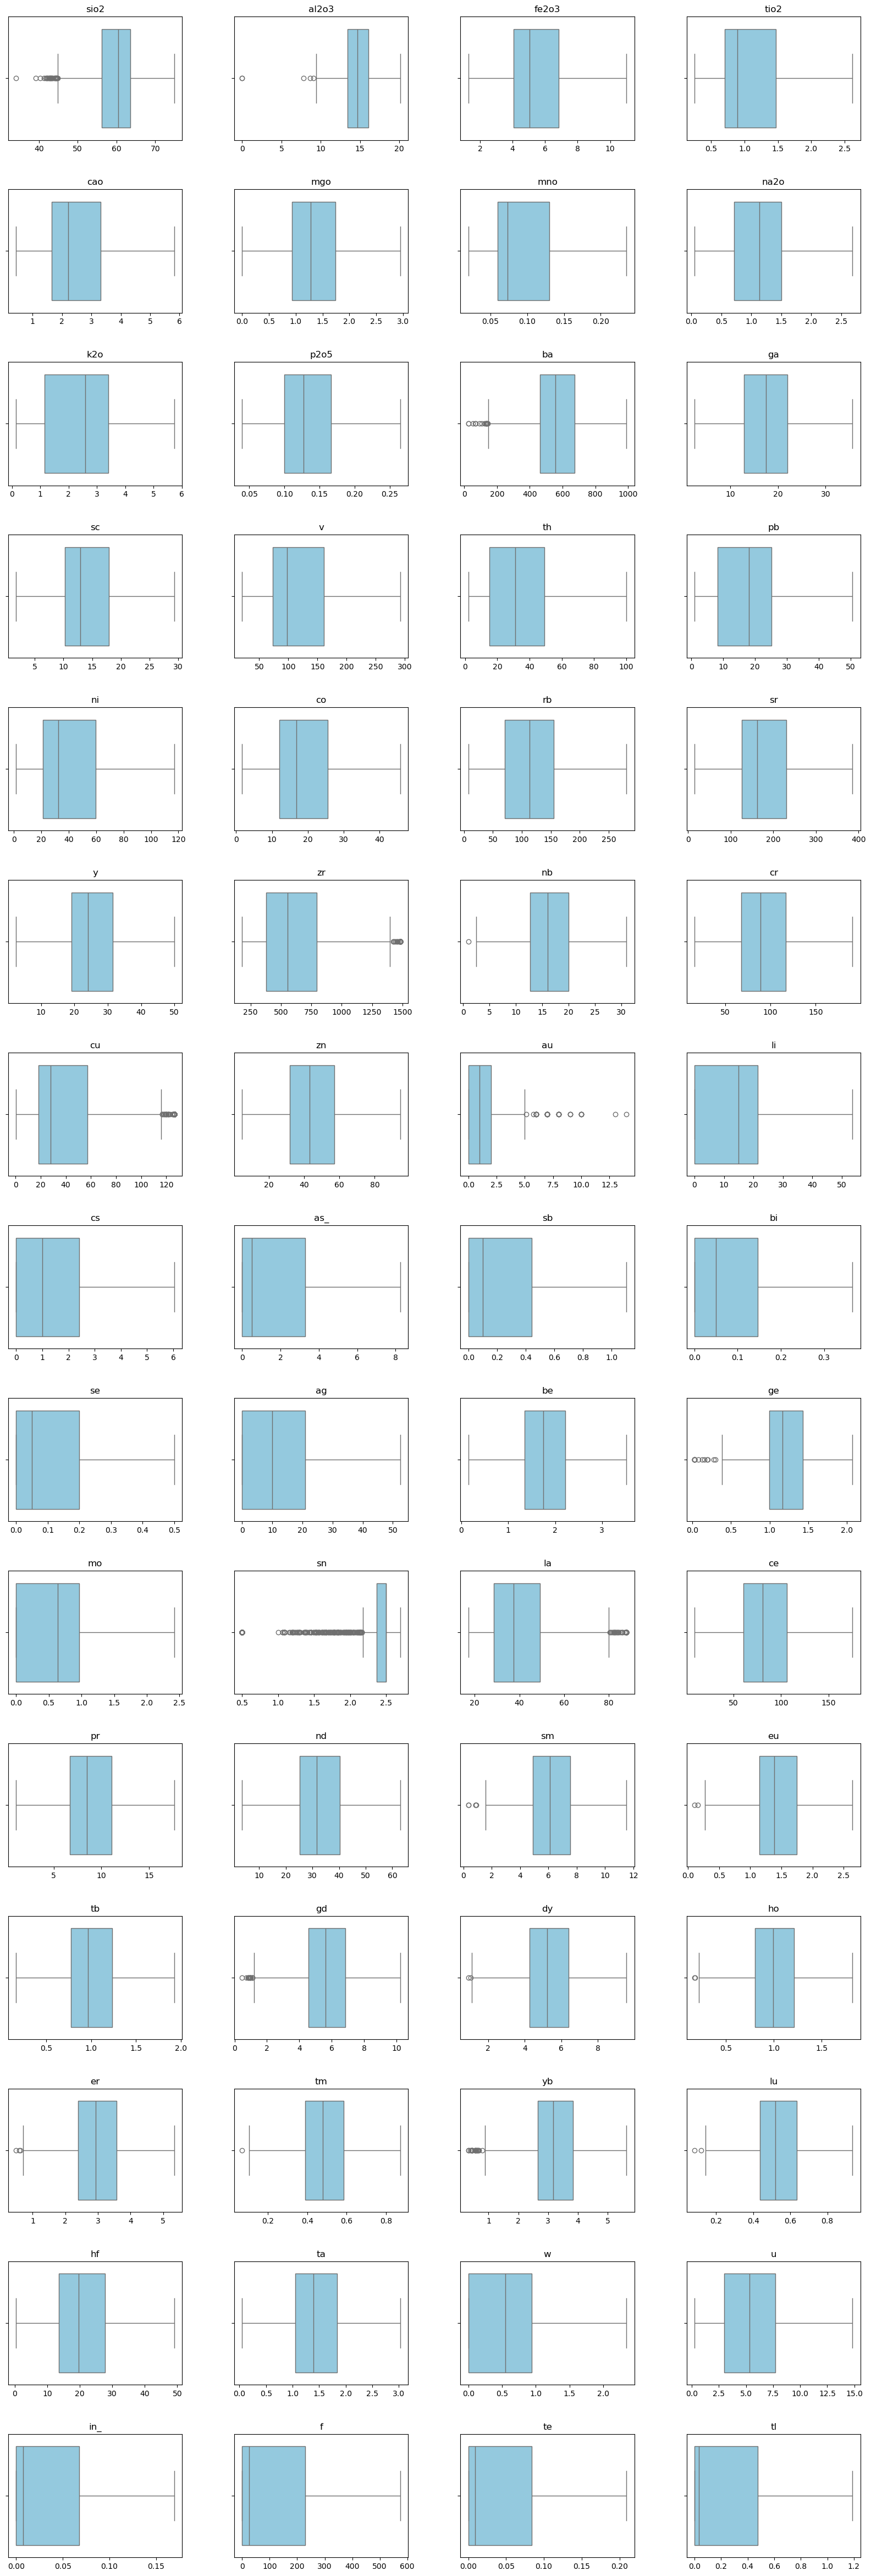

In [146]:
n_elem = len(str_elem)

fig, axes = plt.subplots(nrows=(n_elem+1)//4, 
                         ncols=4, 
                         figsize=(20, 4 * (n_elem//4)))

fig.subplots_adjust(hspace=0.4, wspace=0.3)  # Adjust spacing between plots

# Plot each element in its subplot
for i, (elem, ax) in enumerate(zip(str_sed_data[str_elem].columns, axes.flatten())):
    sns.boxplot(x=str_sed_data[str_elem][elem], 
                ax=ax, 
                color="skyblue")
    ax.set_title(elem)
    ax.set_xlabel('')  # Clear the x-labels if they clutter the plot

#If there are any leftover axes, turn them off
for j in range(i + 1, ((n_elem+1)//4) * 4):
    axes.flatten()[j].set_visible(False)

plt.show()

# Cluster Prediction

## PCA

### Normalize

In [10]:
str_elem_df = str_sed_data[str_elem]

sc = StandardScaler()

norm_str_elem = sc.fit_transform(str_elem_df)

norm_str_elem_df = pd.DataFrame(norm_str_elem, 
                                index=str_elem_df.index, 
                                columns=str_elem)

norm_str_elem_df.head()

,sio2,al2o3,fe2o3,tio2,cao,mgo,mno,na2o,k2o,p2o5,...,hf,ta,w,u,in_,f,te,tl,hg,cd
0,-2.158426,-2.105925,-0.993579,-0.956345,5.808333,0.285078,-0.699363,-1.429562,-0.668466,-0.031546,...,-1.015485,-0.847145,0.037910,-1.020322,-0.694472,1.061576,0.151410,-0.990466,-0.119494,0.071611
1,-2.100516,-1.907179,-0.866083,-0.915068,5.501601,0.134466,-0.274738,-1.396668,-0.709733,-0.877037,...,-0.895480,-0.691304,-0.047473,-0.882946,-0.819041,1.231690,-0.480873,-0.954014,-0.422784,0.071611
2,-0.090626,-0.693429,0.309447,-0.088421,0.047068,0.834082,0.704257,-1.653237,-1.039059,-1.204880,...,-0.845972,0.068389,1.259739,-0.705058,1.622565,-0.360091,0.593105,-0.045615,-0.287988,0.071611
3,0.352027,-1.084581,0.476712,0.022021,-0.188126,0.506947,0.562716,-1.214658,-1.152341,-0.877037,...,-0.809802,0.252522,1.473777,-0.610486,0.294368,-0.056316,-0.511286,-0.317191,-0.355386,0.071611
4,0.217565,-1.175126,0.456242,0.033177,-0.403720,0.344999,0.444765,-1.258516,-1.217074,-1.222135,...,-0.734296,0.130533,0.851046,-0.517053,0.276577,0.794254,-0.601559,-0.220818,-0.490182,0.071611


In [11]:
norm_str_elem_df['cd'] = norm_str_elem_df['cd'].fillna(0)
norm_str_elem_df['hg'] = norm_str_elem_df['hg'].fillna(0)

In [12]:
pca = PCA(n_components=10)
pca.fit(norm_str_elem_df)

PCA(n_components=10)

In [13]:
total_variance = sum(pca.explained_variance_)
desired_variance = 0.75
cumulative_variance = 0
num_comp = 0

for explained_variance_ in pca.explained_variance_:
    cumulative_variance += explained_variance_
    if cumulative_variance / total_variance >= desired_variance:
        break
    num_comp += 1

print(f"Number of components to explain atleast {desired_variance*100}% of variance: {num_comp}")

Number of components to explain atleast 75.0% of variance: 3


In [14]:
pca.explained_variance_ratio_

array([0.25862795, 0.20653638, 0.07007365, 0.04354085, 0.03846875,
       0.03221314, 0.03013268, 0.02702539, 0.02233695, 0.02061087])

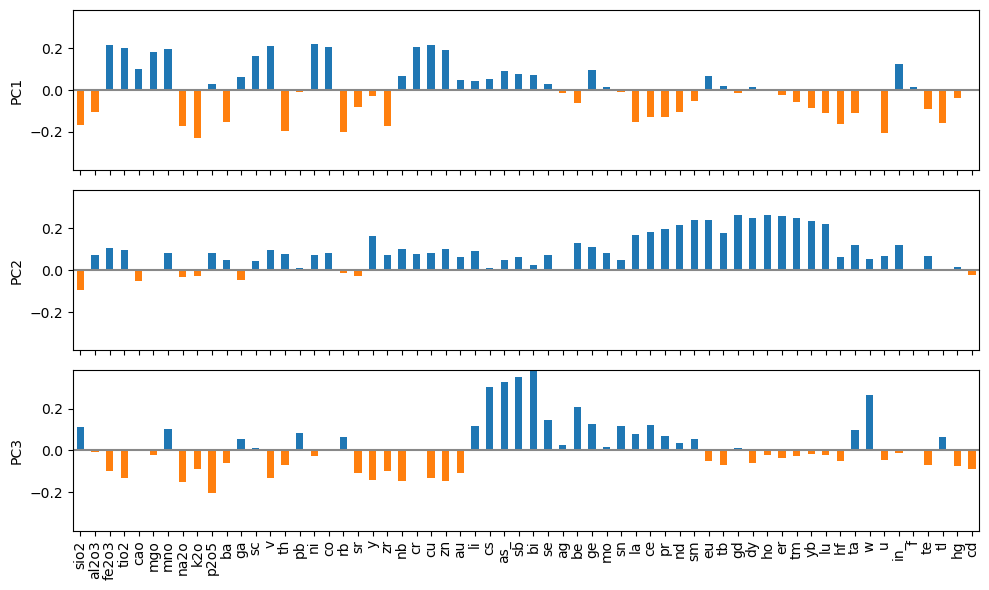

In [15]:
loadings = pca.components_
num_com_to_plot = 3
loadings_to_plot = loadings[:num_com_to_plot]
loadings_df = pd.DataFrame(loadings_to_plot, 
                           columns=str_elem)

# Calculate the maximum absolute value for setting y-axis limits
max_pc = 1.01 * np.max(np.abs(loadings_to_plot))

# Plot loadings for each principal component
fig, axes = plt.subplots(num_com_to_plot, 
                         1, 
                         figsize=(10, 6), 
                         sharex=True)

for i, ax in enumerate(axes):
    pc_loadings = loadings_df.iloc[i]
    colors = ['C0' if l > 0 else 'C1' for l in pc_loadings]
    ax.axhline(color='#888888')
    pc_loadings.plot.bar(ax=ax, color=colors)
    ax.set_ylabel(f'PC{i+1}')
    ax.set_ylim(-max_pc, max_pc)

plt.tight_layout()
plt.show()

### Fit and Transform using PCA on elements

In [16]:
pca = PCA(n_components=3)
pca_elem = pca.fit_transform(norm_str_elem_df)

In [17]:
pca_str_sed_df = pd.concat([str_sed_data[['gid', 'longitude', 'latitude']], 
                            pd.DataFrame(pca_elem, columns=['PC1', 'PC2', 'PC3'])], 
                           axis=1)
pca_str_sed_df.head()

,gid,longitude,latitude,PC1,PC2,PC3
0,274643,77.25,17.00904,2.098653,-5.245274,0.696769
1,274657,77.25,17.02711,1.779361,-4.436358,0.884858
2,274671,77.25,17.04518,3.036876,0.331485,3.740419
3,274685,77.25,17.06325,2.672233,1.406611,3.963623
4,274699,77.25,17.08132,2.681601,0.934711,4.128894


## KMeans Clustering to define clusters/target feature

### Finding the right k

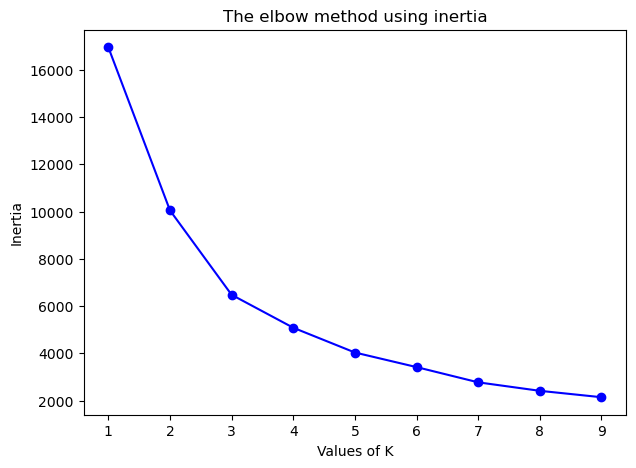

In [18]:
inertia = []                                     ## Sum-of-squared distances
for k in range(1, 10):
    km = KMeans(
        n_clusters=k, init='random',
        n_init=10, max_iter=300, 
        tol=1e-03, random_state=0
    )
    km.fit_predict(pca_str_sed_df[['PC1', 'PC2']])
    inertia.append(km.inertia_)

plt.figure(figsize=(7,5))
plt.plot(range(1, 10), 
         inertia, 
         'bo-')
plt.xlabel('Values of K')
plt.ylabel('Inertia')
plt.title('The elbow method using inertia')
plt.show()

In [30]:
km = KMeans(
    n_clusters=4, init='random',
    n_init=10, max_iter=300, 
    tol=1e-03, random_state=0
)
y_km = km.fit_predict(pca_str_sed_df[['PC1', 'PC2', 'PC3']])

In [31]:
y_km = y_km + 1
np.unique(y_km)

array([1, 2, 3, 4])

In [32]:
clustered_data = pd.concat([str_sed_data[['gid', 'longitude', 'latitude']], 
                            pd.DataFrame(y_km, columns=['clusters'])], 
                           axis=1)

In [33]:
min_lat_limit = sed_min_lat - 1
max_lat_limit = sed_max_lat + 1
min_long_limit = sed_min_long - 1 
max_long_limit = sed_max_long + 1

print(f'Min latitude: {np.round(min_lat_limit, 4)}\tMax latitude: {np.round(max_lat_limit, 4)}')
print(f'Min longitude: {np.round(min_long_limit, 4)}\tMax longitude: {np.round(max_long_limit, 4)}')

Min latitude: 16.009	Max latitude: 18.244
Min longitude: 76.25	Max longitude: 78.9851


### Plot based on each cluster

In [34]:
pca_str_sed_df['cluster'] = clustered_data['clusters']
pca_str_sed_df.head()

,gid,longitude,latitude,PC1,PC2,PC3,cluster
0,274643,77.25,17.00904,2.098653,-5.245274,0.696769,4
1,274657,77.25,17.02711,1.779361,-4.436358,0.884858,4
2,274671,77.25,17.04518,3.036876,0.331485,3.740419,2
3,274685,77.25,17.06325,2.672233,1.406611,3.963623,2
4,274699,77.25,17.08132,2.681601,0.934711,4.128894,2


<Axes: xlabel='PC1', ylabel='PC2'>

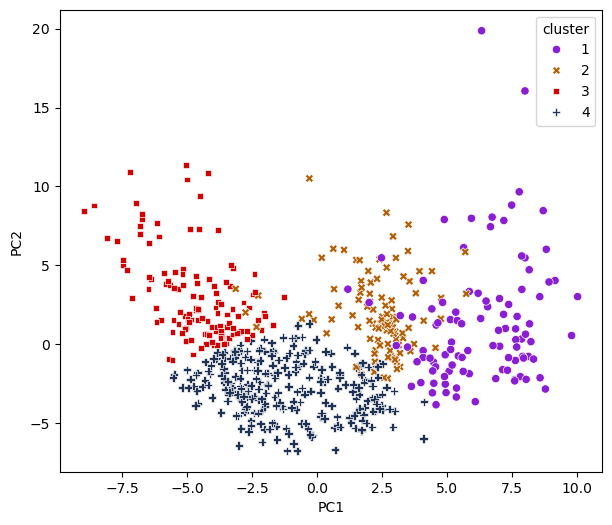

In [35]:
# palette = sns.color_palette("dark", 
#                             as_cmap=False, 
#                             n_colors=len(pca_str_sed_df['cluster'].unique()))

palette = ['#891ed2', '#b45f06', '#d30202', '#203254']

plt.figure(figsize=(7,6))
sns.scatterplot(x='PC1', 
                y='PC2', 
                hue='cluster', 
                style='cluster', 
                data=pca_str_sed_df,
                palette=palette)

In [196]:
# Create a list to store individual figure objects
fig_list = []

# Loop through each cluster
for cluster_id in clustered_data['clusters'].unique():
    # Filter data for the current cluster
    cluster_data = clustered_data[clustered_data['clusters'] == cluster_id]

    hover_text = [f'Sediment ID: {gid}<br>Latitude: {lat}<br>Longitude: {lon}' 
                  for gid, lat, lon in zip(cluster_data['gid'], 
                                           cluster_data['latitude'], 
                                           cluster_data['longitude'])]
    
    # Create a scatter mapbox trace
    trace = go.Scattermapbox(
        lat=cluster_data['latitude'],
        lon=cluster_data['longitude'],
        mode='markers',
        marker=dict(
            size=10,
            color='blue',  # You can assign different colors for each cluster
            opacity=0.8
        ),
        text=hover_text,  # Text to be displayed on hover
        hoverinfo='text'  # Display bore hole id, latitude and longitude text on hover
    )
    
    # Create layout for the map
    layout = go.Layout(
        title=f'Cluster {cluster_id}',
        hovermode='closest',
        mapbox=dict(
            style='open-street-map',  # You can choose different map styles
            center=dict(
                lat=cluster_data['latitude'].mean(),  # Set the map center to the mean of latitudes
                lon=cluster_data['longitude'].mean()  # Set the map center to the mean of longitudes
            ),
            zoom=10, 
            bounds=dict(
                south=min_lat_limit,
                north=max_lat_limit,
                west=min_long_limit,
                east=max_long_limit
            )
        )
    )
    
    # Create figure object and add trace and layout
    fig = go.Figure(data=trace, layout=layout)

    fig.update_layout(
        autosize=False,
        width=700,
        height=700,
    )
    
    # Append the figure to the list
    fig_list.append(fig)

# Display each figure
for fig in fig_list:
    fig.show(renderer='browser')

### Plot combining all clusters

In [37]:
# Assuming clustered_data is your DataFrame and it has 'latitude', 'longitude', 'gid', 'clusters' columns
# colors is your list of color codes, with one color per cluster
colors = ['#891ed2', '#b45f06', '#d30202', '#203254']
# Create separate traces for each cluster
traces = []
for clst in sorted(clustered_data['clusters'].unique()):
    clustered_subset = clustered_data[clustered_data['clusters'] == clst]
    hover_text = [
        f'Latitude: {lat}<br>Longitude: {lon}<br>Sediment ID: {gid}<br>Cluster: {clst}' 
        for lat, lon, gid in zip(clustered_subset['latitude'], 
                                 clustered_subset['longitude'], 
                                 clustered_subset['gid'])
    ]
    
    trace = go.Scattermapbox(
        lat=clustered_subset['latitude'],
        lon=clustered_subset['longitude'],
        mode='markers',
        marker=dict(
            size=10,
            color=colors[clst % len(colors)],  # Assign color for the cluster
            opacity=0.8
        ),
        name=f'Cluster {clst}',  # Name will be used in the legend
        text=hover_text,
        hoverinfo='text'
    )
    traces.append(trace)

# Create layout for the map
layout = go.Layout(
    title='Kodangal Clusters',
    hovermode='closest',
    mapbox=dict(
        style='open-street-map',
        center=dict(
            lat=clustered_data['latitude'].mean(),
            lon=clustered_data['longitude'].mean()
        ),
        zoom=10,
        bounds=dict(
            south=min_lat_limit,
            north=max_lat_limit,
            west=min_long_limit,
            east=max_long_limit
        )
    ),
    legend=dict(
        yanchor="top",
        y=1,
        xanchor="right",
        x=1.1
    )
)

# Create figure object and add traces and layout
fig = go.Figure(data=traces, layout=layout)

fig.update_layout(
    autosize=False,
    width=1300,
    height=1000,
)

# Display the figure
fig.show(renderer='browser')


In [221]:
str_sed_data['cluster'] = clustered_data['clusters']
str_sed_data.head()

,gid,objectid,sampleno,longitude,latitude,sio2,al2o3,fe2o3,tio2,cao,...,w,u,toposheet,in_,f,te,tl,hg,cd,cluster
0,274643,276298,56G04/014/SS/18-19,77.25,17.00904,44.750,9.414,3.312,0.543,5.819375,...,0.991997,1.811020,56G04,0.052741,322.0,0.101815,0.293517,17.0,50.0,3
1,274657,276312,56G04/028/SS/18-19,77.25,17.02711,45.129,9.853,3.748,0.580,5.819375,...,0.943758,2.203597,56G04,0.048799,336.0,0.072979,0.300787,8.0,50.0,3
2,274671,276326,56G04/042/SS/18-19,77.25,17.04518,58.283,12.534,7.768,1.321,2.910000,...,1.682294,2.711943,56G04,0.126064,205.0,0.121959,0.481961,12.0,50.0,1
3,274685,276340,56G04/056/SS/18-19,77.25,17.06325,61.180,11.670,8.340,1.420,2.430000,...,1.803219,2.982200,56G04,0.084033,230.0,0.071592,0.427797,10.0,50.0,1
4,274699,276354,56G04/070/SS/18-19,77.25,17.08132,60.300,11.470,8.270,1.430,1.990000,...,1.451395,3.249200,56G04,0.083470,300.0,0.067475,0.447018,6.0,50.0,1


In [222]:
str_sed_data.to_csv(data_path+'/new_Kodangal_gcM.csv', index=False)